# AusStage - Preliminary analysis

<style>
  a {
    color: #1ea5a6 !important;
  }
</style>

This is an exploratory data analysis of collected data from [AusStage](https://www.ausstage.edu.au/pages/browse/) with a focus on gender and roles. Throughout this analysis we use data that has also been filtered down to 253 person records with the richest data. We refer to this subset as `AusStage253`.

### Import packages and data
We import data from the [data/analysis folder](https://github.com/acd-engine/jupyterbook/tree/main/data/analysis) located in Github.

In [585]:
# for data mgmt
import json
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import os, requests, gzip, io
import ast

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from itables import show

import warnings
warnings.filterwarnings("ignore")

# provide folder_name which contains uncompressed data i.e., csv and jsonl files
# only need to change this if you have already donwloaded data
# otherwise data will be fetched from google drive
global folder_name
folder_name = 'data/local'

def fetch_small_data_from_github(fname):
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/{fname}"
    if 'xlsx' in fname: return pd.read_excel(url)
    else:
        response = requests.get(url)
        rawdata = response.content.decode('utf-8')
        return pd.read_csv(io.StringIO(rawdata))

def fetch_date_suffix():
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/date_suffix"
    response = requests.get(url)
    rawdata = response.content.decode('utf-8')
    try: return rawdata[:12]
    except: return None

def check_if_csv_exists_in_folder(filename):
    try: return pd.read_csv(os.path.join(folder_name, filename), low_memory=False)
    except: return None

def fetch_data(filetype='csv', acdedata='organization'):
    filename = f'acde_{acdedata}_{fetch_date_suffix()}.{filetype}'

    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(filename)
    if data_from_path is not None: return data_from_path

    urls = fetch_small_data_from_github('acde_data_gdrive_urls.csv')
    sharelink = urls[urls.data == acdedata][filetype].values[0]
    url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'

    response = requests.get(url)
    decompressed_data = gzip.decompress(response.content)
    decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))

    try:
        if filetype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
        else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
        return pd.DataFrame(df)
    except: return None 

acde_persons = fetch_data(acdedata='person')
ausstage_persons = acde_persons[acde_persons.data_source.str.contains('AusStage')]
ausstage_persons['ori_id'] = ausstage_persons.ori_id.astype(int)
ausstage_253 = fetch_small_data_from_github('AusStage253.xlsx')
ausstage_253_cols = ['original_id','state','birth_place','birth_date_yyyy','death_place','death_date_yyyy']

ausstage_253_merged = pd.merge(ausstage_persons, ausstage_253[ausstage_253_cols], left_on='ori_id', 
                               right_on='original_id', how='right')

del ausstage_253

### High-level overview

We begin by computing some basic insights of the data, specifically fields that have been updated.

These include:
- `state`
- `birth_place`
- `birth_date_yyyy`
- `death_place`
- `death_place_yyyy`

The first plot displays the frequency of each state, according to `AusStage253` person records. A majority of the records are from Victoria and New South Wales. Next we provide an overview of the remaining fields, in terms of the top 5 most frequently occuring values and missingness.

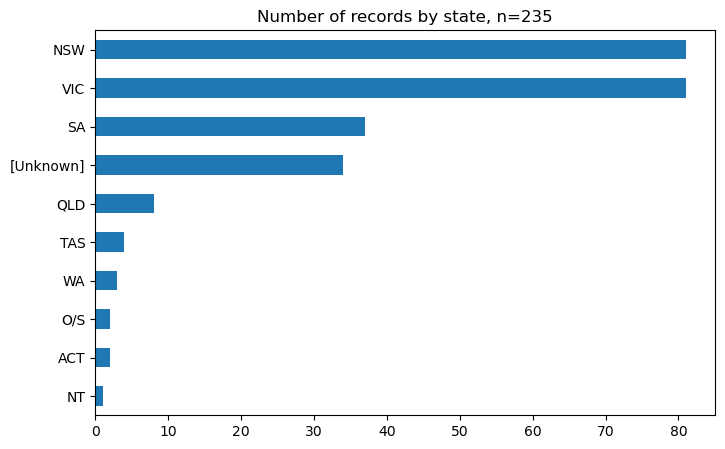

In [586]:
ausstage_253_merged['state']\
    .value_counts()\
    .sort_values()\
    .plot(kind='barh', figsize=(8, 5), legend=False)

plt.title('Number of records by state, n=235')
plt.show()

In [92]:
missing_vals = ausstage_253_merged['birth_place'].isnull().sum()
print("There are {} ({}%) rows with missing birth_place in the dataset."\
      .format(missing_vals, round(100*(missing_vals/ausstage_253_merged.shape[0]), 1)))

print("\nThese are the top 5 values in the birth_place column.")
print(ausstage_253_merged['birth_place'].value_counts().head(5))

missing_vals = ausstage_253_merged['birth_date_yyyy'].isnull().sum()
print("\nThere are {} ({}%) rows with missing birth_date_yyyy in the dataset."\
      .format(missing_vals, round(100*(missing_vals/ausstage_253_merged.shape[0]), 1)))

print("\nThese are the top 5 values in the birth_date_yyyy column.")
print(ausstage_253_merged['birth_date_yyyy'].value_counts().head(5))

missing_vals = ausstage_253_merged['death_place'].isnull().sum()
print("\nThere are {} ({}%) rows with missing death_place in the dataset."\
      .format(missing_vals, round(100*(missing_vals/ausstage_253_merged.shape[0]), 1)))

print("\nThese are the top 5 values in the death_place column.")
print(ausstage_253_merged['death_place'].value_counts().head(5))

missing_vals = ausstage_253_merged['death_date_yyyy'].isnull().sum()
print("\nThere are {} ({}%) rows with missing death_date_yyyy in the dataset."\
      .format(missing_vals, round(100*(missing_vals/ausstage_253_merged.shape[0]), 1)))

print("\nThese are the top 5 values in the death_date_yyyy column.")
print(ausstage_253_merged['death_date_yyyy'].value_counts().head(5))

There are 159 (62.8%) rows with missing birth_place in the dataset.

These are the top 5 values in the birth_place column.
Melbourne    18
Sydney       15
Adelaide     13
Ballarat      3
Tamworth      3
Name: birth_place, dtype: int64

There are 140 (55.3%) rows with missing birth_date_yyyy in the dataset.

These are the top 5 values in the birth_date_yyyy column.
1967.0    6
1961.0    6
1966.0    5
1962.0    5
1943.0    5
Name: birth_date_yyyy, dtype: int64

There are 247 (97.6%) rows with missing death_place in the dataset.

These are the top 5 values in the death_place column.
Sydney        2
Double Bay    1
Canberra      1
Perth         1
Toowoomba     1
Name: death_place, dtype: int64

There are 237 (93.7%) rows with missing death_date_yyyy in the dataset.

These are the top 5 values in the death_date_yyyy column.
2022.0    3
2021.0    2
2019.0    1
2023.0    1
2001.0    1
Name: death_date_yyyy, dtype: int64


### Gender

We compare the gender proportions of `AusStage253` with the entire AusStage persons dataset which consists of over 180k persons. 

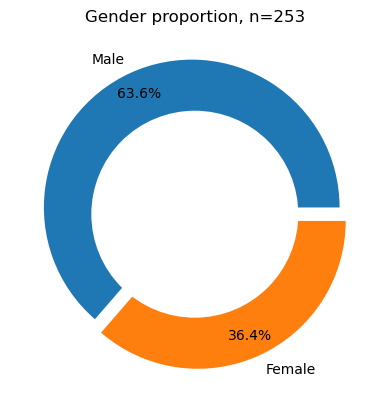

In [146]:
## Gender Proportion
df_gender=ausstage_253_merged['gender']\
    .value_counts()\
    .reset_index()\
    .rename({"index":"Gender", "gender":"Frequency"}, axis=1)

# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender[~df_gender['Gender'].isnull()]['Frequency'], labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85, colors=['tab:blue','tab:orange'],
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion, n=253')
  
# Displaying Chart
plt.show()

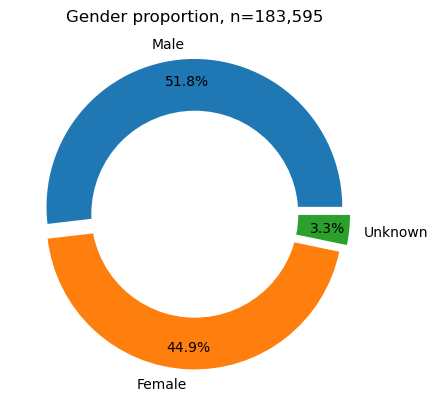

In [166]:
## Gender Proportion
df_gender=ausstage_persons['gender']\
    .value_counts()\
    .reset_index()\
    .rename({"index":"Gender", "gender":"Frequency"}, axis=1)

# explosion
explode = (0.05, 0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender['Frequency'], labels=['Male','Female','Unknown'],
        autopct='%1.1f%%', pctdistance=0.85, colors=['tab:blue','tab:orange','tab:green'],
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion, n=183,595')
  
# Displaying Chart
plt.show()

<br>

For further context, we visualise the number of active males and females over time for all AusStage records. We capture this activity by filtering on people that have a career start date and end date. The plot below shows a count of the cumulative career activity.

In [121]:
# # daao_daqa_ausstage = acde_persons[acde_persons.data_source.str\
# #                          .contains('DAQA|DAAO|AusStage')][['gender', 'data_source', 'birth','death','career']]
# # daao_daqa_ausstage = daao_daqa_ausstage[daao_daqa_ausstage['career'].notnull()]

# # selected_idx = []
# # selected_birth_year = [] 
# # selected_start_year = []
# # selected_end_year = []
# # selected_death_year = []

# # for idx,row in daao_daqa_ausstage.iterrows():
# #     try: selected_birth_year.append(int(pd.json_normalize(json.loads(row['birth']))['coverage.date.year'].values[0]))
# #     except: selected_birth_year.append(np.nan)

# #     try:
# #         career_df = pd.json_normalize(pd.json_normalize(json.loads(row['career']))['career_periods'].values[0])
# #         selected_start_year.append(career_df['coverage_range.date_range.date_start.year'].min())
# #     except: selected_start_year.append(np.nan)

# #     try:
# #         career_df = pd.json_normalize(pd.json_normalize(json.loads(row['career']))['career_periods'].values[0])
# #         selected_end_year.append(career_df['coverage_range.date_range.date_end.year'].max())
# #     except: selected_end_year.append(np.nan)

# #     try: selected_death_year.append(int(pd.json_normalize(json.loads(row['death']))['coverage.date.year'].values[0]))
# #     except: selected_death_year.append(np.nan)

# # # daao_daqa = daao_daqa[daao_daqa.index.isin(selected_idx)].copy()
# # daao_daqa_ausstage['birth_year'] = selected_birth_year
# # daao_daqa_ausstage['career_start'] = selected_start_year
# # # return max year of selected_end_year and death_year, there may be nan values
# # daao_daqa_ausstage['career_end'] = selected_end_year
# # daao_daqa_ausstage['death_year'] = selected_start_year

# # # manipulate career_start so that each value contains the first 4 digits
# # daao_daqa_ausstage['career_start'] = daao_daqa_ausstage['career_start'].apply(lambda x: np.nan if isinstance(x,float) else str(x)[:4])
# # daao_daqa_ausstage['career_end'] = daao_daqa_ausstage['career_end'].apply(lambda x: np.nan if isinstance(x,float) else str(x)[:4])
# # daao_daqa_ausstage['death_year'] = daao_daqa_ausstage['death_year'].apply(lambda x: np.nan if isinstance(x,float) else str(x)[:4])

# # # change all strings that are not numbers to nan
# # daao_daqa_ausstage['career_start'] = daao_daqa_ausstage['career_start'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
# # daao_daqa_ausstage['career_end'] = daao_daqa_ausstage['career_end'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
# # daao_daqa_ausstage['death_year'] = daao_daqa_ausstage['death_year'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)

# daao_daqa_ausstage = daao_daqa_ausstage[daao_daqa_ausstage['gender'].notnull()]
# daao_daqa_ausstage['gender'] = daao_daqa_ausstage['gender'].apply(lambda x: str(x.replace('"', '')))
# daao_daqa_ausstage['data_source'] = daao_daqa_ausstage['data_source'].apply(lambda x: str(x.replace('"', '')))
# daao_daqa_ausstage = daao_daqa_ausstage[daao_daqa_ausstage['gender']\
#     .str.contains('ale')][['gender','data_source','birth_year','death_year','career_start','career_end']]

# daao_daqa_ausstage = daao_daqa_ausstage[(daao_daqa_ausstage.death_year.notnull()) | (daao_daqa_ausstage.career_end.notnull())].copy()
# daao_daqa_ausstage['career_end'] = daao_daqa_ausstage['career_end'].fillna(-1)
# daao_daqa_ausstage['death_year'] = daao_daqa_ausstage['death_year'].fillna(-1)
# daao_daqa_ausstage['career_end'] = np.where(daao_daqa_ausstage['career_end'] > daao_daqa_ausstage['death_year'], 
#                                             daao_daqa_ausstage['career_end'], daao_daqa_ausstage['death_year'])

# daao_daqa_ausstage = daao_daqa_ausstage[daao_daqa_ausstage['career_start'].notnull()][['gender','data_source','career_start','career_end']]
# daao_daqa_ausstage = daao_daqa_ausstage[daao_daqa_ausstage['career_start'] != daao_daqa_ausstage['career_end']]
# daao_daqa_ausstage.reset_index(inplace=True, drop=True)

# daao_daqa_ausstage_wide = pd.DataFrame()

# for i,row in daao_daqa_ausstage.iterrows():
#     for year in range(int(row['career_start']), int(row['career_end'])+1): 
#         daao_daqa_ausstage_wide.loc[i, year] = 1

# daao_daqa_ausstage_wide = daao_daqa_ausstage_wide.fillna(0)
# daao_daqa_ausstage_wide = pd.merge(daao_daqa_ausstage, daao_daqa_ausstage_wide, left_index=True, right_index=True)

# daao_females_wide = daao_daqa_ausstage_wide[(daao_daqa_ausstage_wide.gender == 'female') & (daao_daqa_ausstage_wide.data_source == 'DAAO')].copy()
# daao_males_wide = daao_daqa_ausstage_wide[(daao_daqa_ausstage_wide.gender == 'male') & (daao_daqa_ausstage_wide.data_source == 'DAAO')].copy()
# daqa_females_wide = daao_daqa_ausstage_wide[(daao_daqa_ausstage_wide.gender == 'female') & (daao_daqa_ausstage_wide.data_source == 'DAQA')].copy()
# daqa_males_wide = daao_daqa_ausstage_wide[(daao_daqa_ausstage_wide.gender == 'male') & (daao_daqa_ausstage_wide.data_source == 'DAQA')].copy()
# ausstage_females_wide = daao_daqa_ausstage_wide[(daao_daqa_ausstage_wide.gender == 'Female') & (daao_daqa_ausstage_wide.data_source == 'AusStage')].copy()
# ausstage_males_wide = daao_daqa_ausstage_wide[(daao_daqa_ausstage_wide.gender == 'Male') & (daao_daqa_ausstage_wide.data_source == 'AusStage')].copy()

# daao_females_wide = daao_females_wide.drop(['gender','data_source','career_start','career_end'], axis=1)
# daao_males_wide = daao_males_wide.drop(['gender','data_source','career_start','career_end'], axis=1)

# daao_gender_count = pd.merge(daao_males_wide.sum().reset_index().sort_values('index', ascending=True),
#                             daao_females_wide.sum().reset_index().sort_values('index', ascending=True), 
#                             on='index', how='outer')

# daao_gender_count.columns = ['year','male','female']
# daao_gender_count['data_source'] = 'DAAO'

# daqa_females_wide = daqa_females_wide.drop(['gender','data_source','career_start','career_end'], axis=1)
# daqa_males_wide = daqa_males_wide.drop(['gender','data_source','career_start','career_end'], axis=1)

# daqa_gender_count = pd.merge(daqa_males_wide.sum().reset_index().sort_values('index', ascending=True),
#                             daqa_females_wide.sum().reset_index().sort_values('index', ascending=True), 
#                             on='index', how='outer')

# daqa_gender_count.columns = ['year','male','female']
# daqa_gender_count['data_source'] = 'DAQA'

# ausstage_females_wide = ausstage_females_wide.drop(['gender','data_source','career_start','career_end'], axis=1)
# ausstage_males_wide = ausstage_males_wide.drop(['gender','data_source','career_start','career_end'], axis=1)

# ausstage_gender_count = pd.merge(ausstage_males_wide.sum().reset_index().sort_values('index', ascending=True),
#                                 ausstage_females_wide.sum().reset_index().sort_values('index', ascending=True), 
#                                 on='index', how='outer')

# ausstage_gender_count.columns = ['year','male','female']
# ausstage_gender_count['data_source'] = 'AusStage'

# daqa_daao_ausstage_gender_count = pd.concat([daao_gender_count, daqa_gender_count, ausstage_gender_count])
# daqa_daao_ausstage_gender_count.to_csv('data/local/AusStage_gender_comparison.csv', index=False)

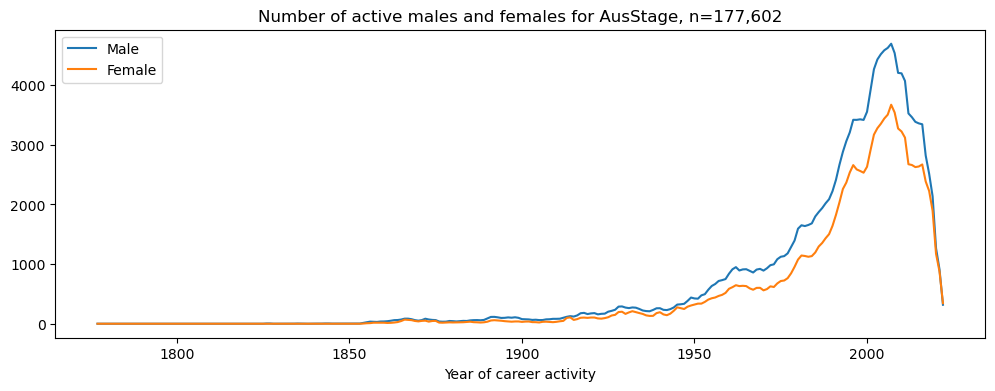

In [167]:
daqa_daao_ausstage_gender_count = fetch_small_data_from_github('AusStage_gender_comparison.csv')

plt.plot(daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'AusStage']['year'], 
daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'AusStage']['male'], 
label='Male', color='tab:blue')

plt.plot(daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'AusStage']['year'], 
daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'AusStage']['female'], 
label='Female', color='tab:orange')

plt.title('Number of active males and females for AusStage, n=177,602')
plt.xlabel('Year of career activity')

plt.legend()

# increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(12, 4)

plt.show()

<br>

To extend the above plot, we also visualise the proportion of active males and females over time, and compare with DAQA and DAAO records. The visualisation suggest that the gender disparity is not as pronounced in DAAO and AusStage as it is in DAQA.

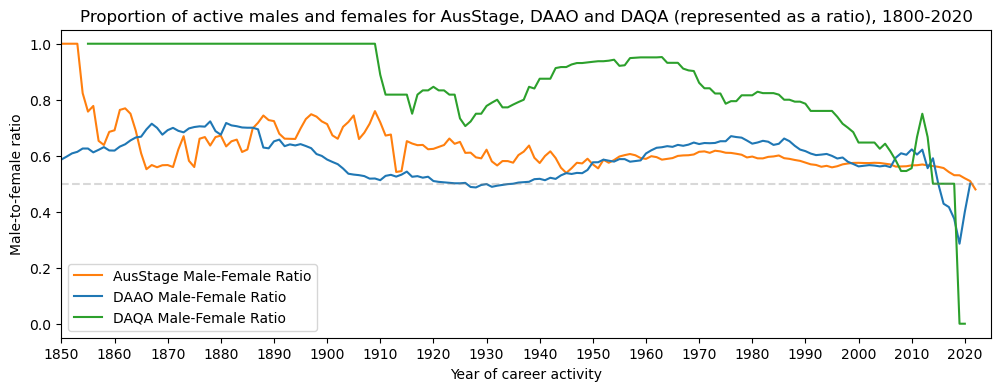

In [136]:
daqa_daao_ausstage_gender_count['male_to_female'] = (daqa_daao_ausstage_gender_count.male/(daqa_daao_ausstage_gender_count.male + daqa_daao_ausstage_gender_count.female))

# plot
plt.plot(daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'AusStage']['year'], 
daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'AusStage']['male_to_female'], 
label='AusStage Male-Female Ratio', color='tab:orange')

plt.plot(daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'DAAO']['year'], 
daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'DAAO']['male_to_female'], 
label='DAAO Male-Female Ratio', color='tab:blue')

plt.plot(daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'DAQA']['year'], 
daqa_daao_ausstage_gender_count[daqa_daao_ausstage_gender_count.data_source == 'DAQA']['male_to_female'], 
label='DAQA Male-Female Ratio', color='tab:green')

plt.title('Proportion of active males and females for AusStage, DAAO and DAQA (represented as a ratio), 1800-2020')
plt.ylabel('Male-to-female ratio')
plt.xlabel('Year of career activity')

plt.legend()

# change x-axis limit
plt.xlim(1850, 2025)

# change x-axis tick frequency
plt.xticks(np.arange(1850, 2025, 10))

# add line at 50% mark
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.3)

# increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(12, 4)

plt.show()

### Career trajectories of `AusStage253` persons

We start by calculating the number of roles per person as provided in the `career` field. We then plot the distribution of the number of roles per person. On average, `AusStage253` persons have 6.7 unique roles.

In [560]:
event_data = pd.DataFrame()

for idx,row in ausstage_253_merged.iterrows():
    # skip if no related events
    try:
        rel_events = pd.json_normalize(pd.json_normalize(json.loads(row['career']))['career_periods'][0])

        # add person info
        rel_events['ori_id'] = row.ori_id
        rel_events['display_name'] = row.display_name
        rel_events['gender'] = row.gender
        rel_events['state'] = row.state

        # add to exhibition_data
        event_data = pd.concat([event_data, rel_events], axis=0)
    except: pass

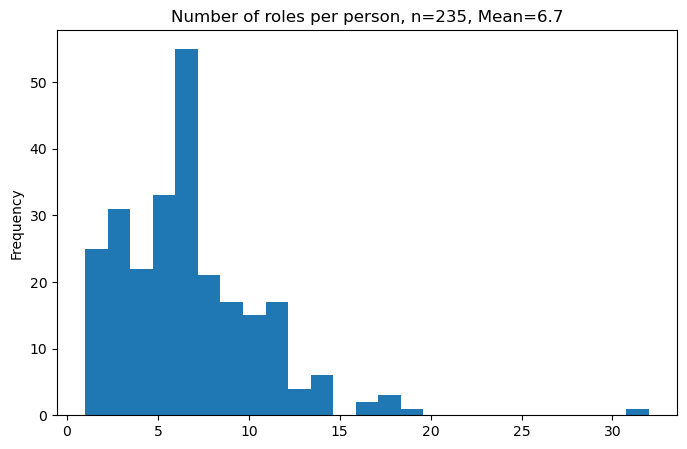

In [561]:
# average number of roles
no_roles = event_data[['occupation.title','ori_id']]\
            .drop_duplicates()[['ori_id','occupation.title']]\
            .value_counts().reset_index()['ori_id']\
            .value_counts()

no_roles.plot(kind='hist', bins=25, figsize=(8,5), 
              title=f'Number of roles per person, n=235, Mean={round(no_roles.mean(),1)}')

plt.show()

<br>

Most of the data clusters around the mean, however there a few outliers that are skewing the data. We list the top five outliers below.

In [562]:
# top 5
pd.merge(no_roles.head(5).reset_index().rename(columns={'index':'ori_id', 'ori_id':'Role Count'}), 
         event_data[['ori_id', 'display_name']], on='ori_id', how='left').drop_duplicates()[['display_name', 'Role Count']]

,display_name,Role Count
0,"""Mr Robert Kenneth Leslie Taylor""",32
562,"""Catherine Fitzgerald""",19
782,"""Eddie Perfect""",18
898,"""Sean Weatherly""",18
1012,"""Jim Sharman""",18


<br>

Beyond the number of roles per person, we also inspect the most frequent roles in terms of participation frequency. We list the top ten roles according to the `AusStage253` subset. Most people are recorded as **actors**.

We also assess the number of distinct roles per person. The average number of distinct roles per person is 1.5. The maximum number of distinct roles per person is 5. Here we can see that 225 out of 253 people have held an actor role (89%). This is followed by director, which is held by 142 people, roughly half of the people in the `AusStage253` dataset.

In [568]:
# number of roles for all events
event_data['occupation.title'].value_counts().head(10)

Actor                10147
Director              4085
Lighting Designer     2458
Performer             1022
Designer               955
Playwright             710
Writer                 502
Adaptor                483
Devisor                423
Stage Manager          391
Name: occupation.title, dtype: int64

<br>

We also assess the number of distinct roles per person. The average number of distinct roles per person is 1.5. The maximum number of distinct roles per person is 5. Here we can see that 225 out of 253 people have held an actor role (89%). This is followed by director, which is held by 142 people, roughly half of the people in the `AusStage253` dataset.

In [565]:
# Count of distinct roles for each person

events_occupations = event_data[['occupation.title','ori_id']]\
    .drop_duplicates()['occupation.title']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index':'Occupation','occupation.title':'Count'})
    
# add proportion column
events_occupations['Percentage (out of 253)'] = round((events_occupations['Count']/253)*100,2)
events_occupations.head(20)

,Occupation,Count,Percentage (out of 253)
0,Actor,225,88.93
1,Director,142,56.13
2,Performer,125,49.41
3,Writer,63,24.90
4,Devisor,62,24.51
5,Playwright,60,23.72
6,Designer,50,19.76
7,Actor and Singer,50,19.76
8,Assistant Director,49,19.37
9,Adaptor,47,18.58


<br>

The initial plan was to consider the average career span of different roles, however we did find that there were over 4000 missing values for career end year data for roles. This differs greatly to career start year data, which has no missing data. Therefore, we focus more on the average career span for each person.

We first plot the distribution of career start date for each role records for each person. The data peaks around the 2010s. We provide this by year and by decade.

There are 4460 (17.0%) missing values in the coverage_range.date_range.date_end.year column.



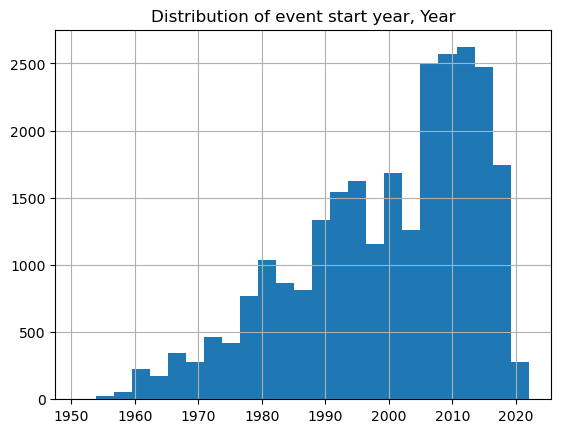

In [566]:
missing_vals = event_data['coverage_range.date_range.date_end.year'].isnull().sum()
missing_vals_prop = round(100*(missing_vals / len(event_data)),1)
print(f'There are {missing_vals} ({missing_vals_prop}%) missing values in the coverage_range.date_range.date_end.year column.\n')

event_data['coverage_range.date_range.date_start.year'] = event_data['coverage_range.date_range.date_start.year'].astype(int)
event_data['coverage_range.date_range.date_end.year'].fillna(event_data['coverage_range.date_range.date_start.year'], inplace=True)
event_data['coverage_range.date_range.date_end.year'] = event_data['coverage_range.date_range.date_end.year'].astype(int)

event_data['coverage_range.date_range.date_start.year'].astype(int).hist(bins=25)
plt.title('Distribution of event start year, Year')
plt.show()

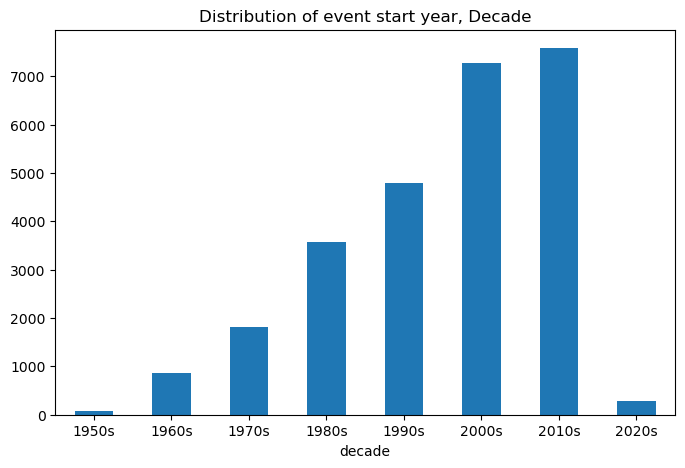

In [567]:
event_data['decade'] = event_data['coverage_range.date_range.date_start.year'].apply(lambda x: str(x)[:3] + '0s')
event_data['decade'].value_counts().reset_index().sort_values('index').rename(columns={'index': 'decade', 'decade': 'count'})\
    .plot.bar(x='decade', y='count', figsize=(8, 5), title='Distribution of event start year, Decade', rot=0, legend=False)
plt.show()

<br>

Next we iterate over each person's roles and define their career start date by subtracting the start date years of the last role and first role. The histogram and boxplot below highlights the distribution.

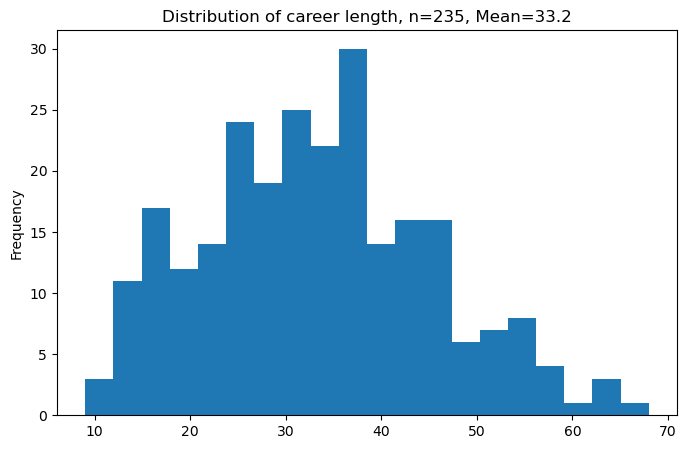

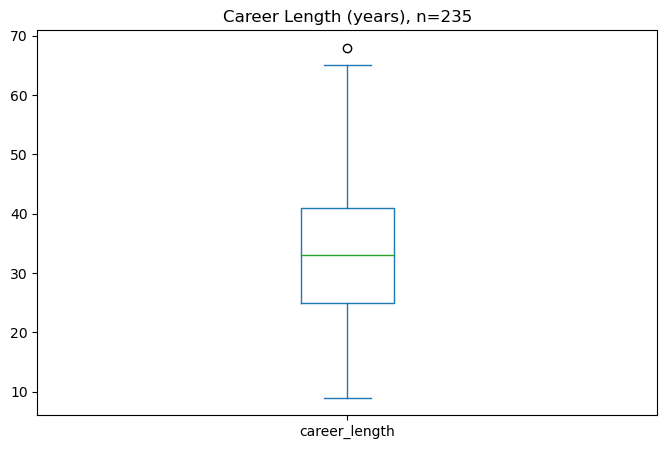

In [440]:
career_tenure = []

for id in event_data['display_name'].unique():
    firstyear = event_data[event_data['display_name'] == id]['coverage_range.date_range.date_start.year'].min()
    lastyear = event_data[event_data['display_name'] == id]['coverage_range.date_range.date_start.year'].max()
    career_tenure.append([id, firstyear, lastyear])

career_tenure = pd.DataFrame(career_tenure, columns=['display_name', 'firstyear', 'lastyear'])
career_tenure['career_length'] = (career_tenure['lastyear'] - career_tenure['firstyear'] + 1)

career_tenure['career_length'].plot.hist(bins=20, figsize=(8, 5), 
                                         title=f'Distribution of career length, n=235, Mean={round(career_tenure.career_length.mean(),1)}')
plt.show()

career_tenure['career_length'].plot.box(figsize=(8, 5), title='Career Length (years), n=235', vert=True)
plt.show()

<br>

We also assess the average duration for each person's role which calculates to be roughly one year for each record. Some roles such as Stage Director, Casting Director and Original Director tend to be slightly higher i.e., over 1.25 years on average. Below the plot, we provide top five roles based on average duration.

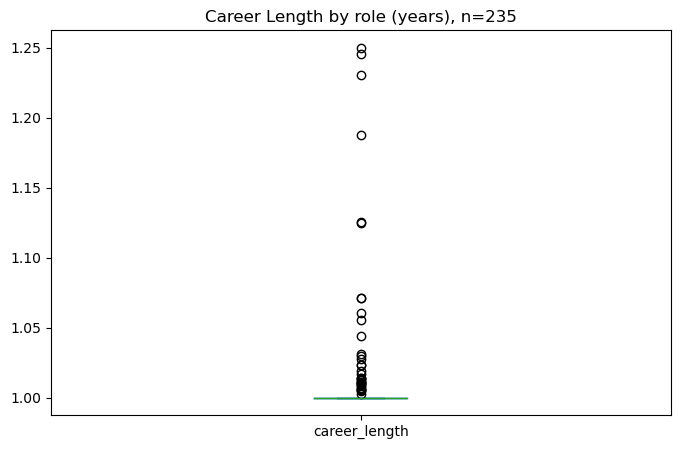

In [441]:
career_byrole_tenure = []

for id in event_data['occupation.title'].unique():
    this_role = event_data[event_data['occupation.title'] == id]
    thisrole_count = this_role['display_name'].nunique()
    career_length = (this_role['coverage_range.date_range.date_end.year'] - this_role['coverage_range.date_range.date_start.year'] + 1).mean()
    career_byrole_tenure.append([id, career_length, thisrole_count])

career_byrole_tenure = pd.DataFrame(career_byrole_tenure, columns=['occupation.title', 'career_length', 'unique_person_count'])
career_byrole_tenure['career_length'].plot.box(figsize=(8, 5), title='Career Length by role (years), n=235', vert=True)
plt.show()

In [442]:
career_byrole_tenure.sort_values('career_length', ascending=False).head(5)

,occupation.title,career_length,unique_person_count
117,Stage Director,1.250000,4
144,Casting Director,1.245283,2
63,Original Director,1.230769,4
92,Resident Director,1.187500,5
17,Actor and Singer,1.125749,50


<br>

Note that most of the roles above only have a handful of records (see `unique_person_count` column). Therefore, we apply a filter to only consider roles with more than 30 records. This leaves us with fifteen role types.

In [443]:
# top 15 roles by number of people
top15 = career_byrole_tenure[career_byrole_tenure.unique_person_count > 30] 
top15.sort_values(by=['career_length'], ascending=False)

,occupation.title,career_length,unique_person_count
17,Actor and Singer,1.125749,50
4,Actor,1.023061,225
32,Designer,1.023037,50
7,Producer,1.017094,34
43,Devisor,1.014184,62
35,Writer,1.013944,63
37,Director,1.013464,142
16,Performer,1.012720,125
33,Set Designer,1.010782,36
56,Adaptor,1.008282,47


### Drilldown into top 15 roles

We now will visualise career trajectories by gender and role. We show this as a frequency over time and as a proportion over time. This will allow us to identify any role-specific trends across gender and time. We inspect the top fifteen roles with the largest frequency in the `AusStage253` data.

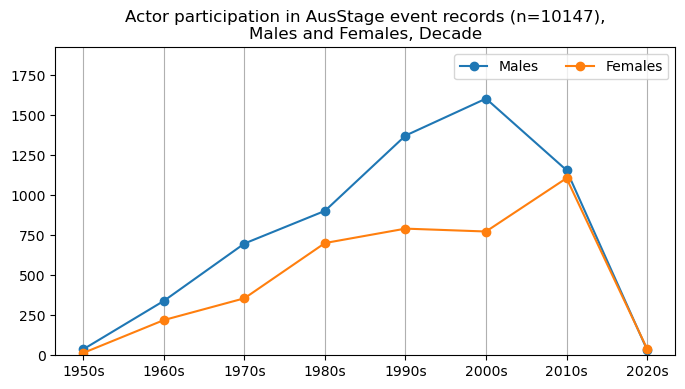

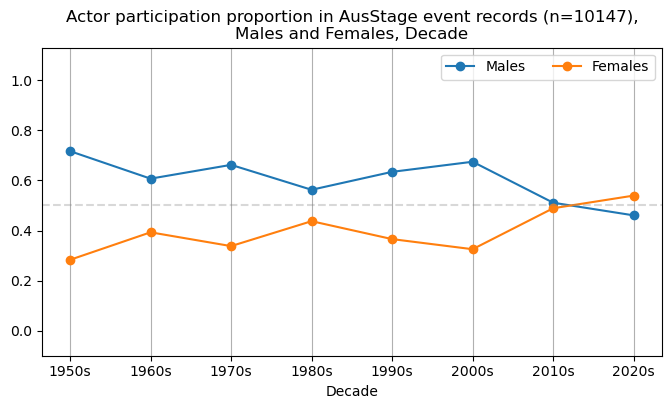

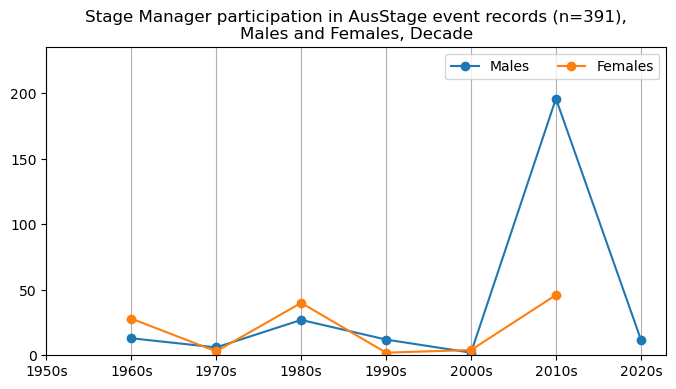

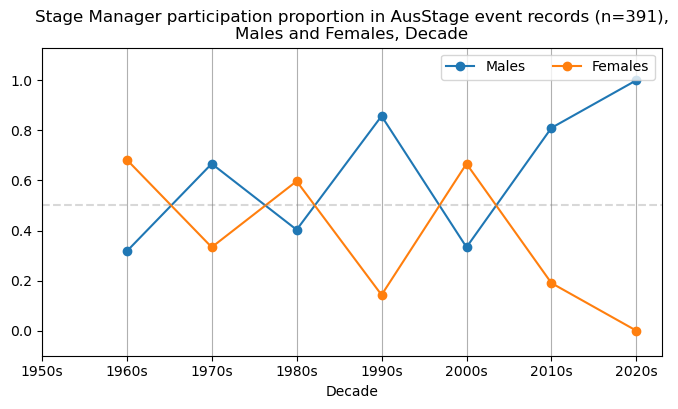

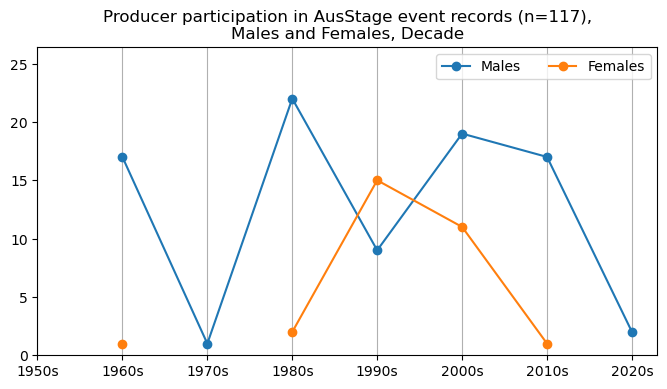

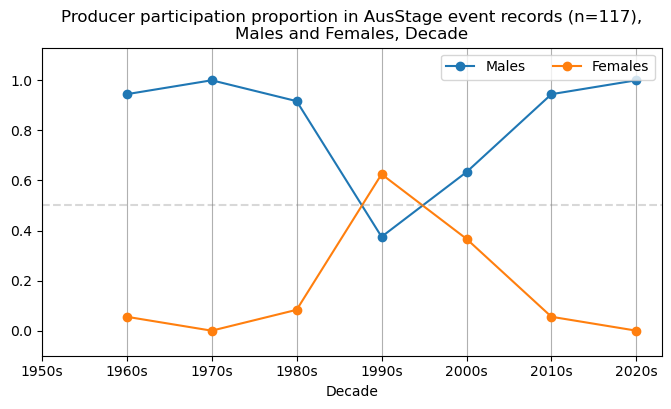

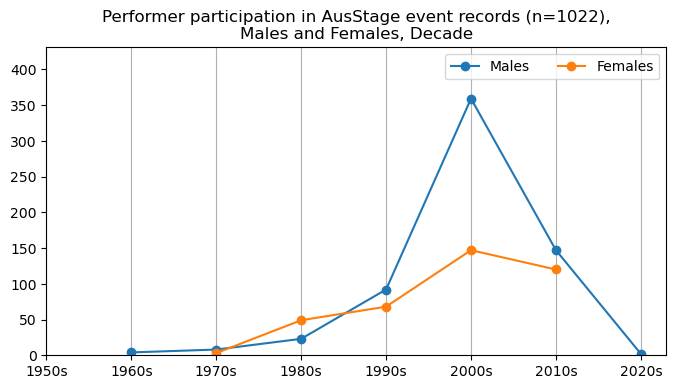

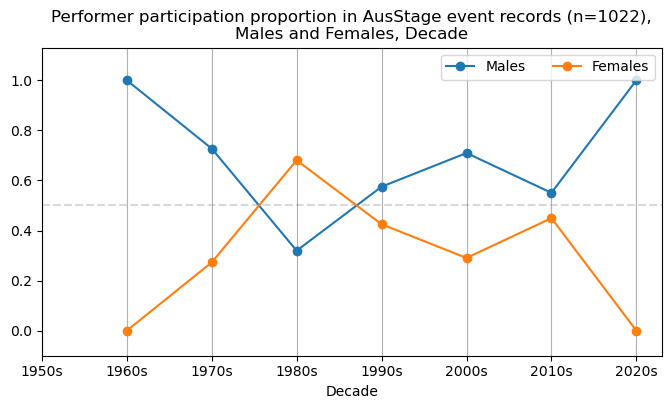

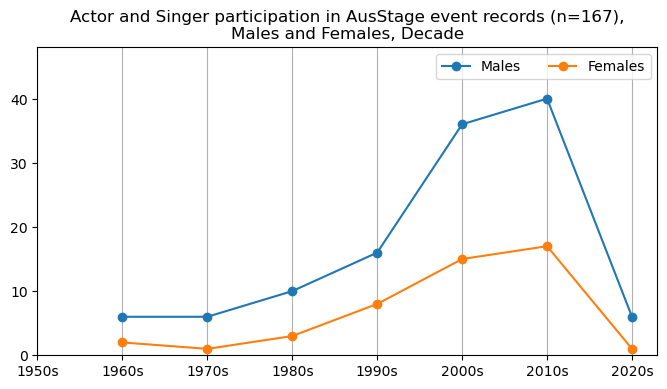

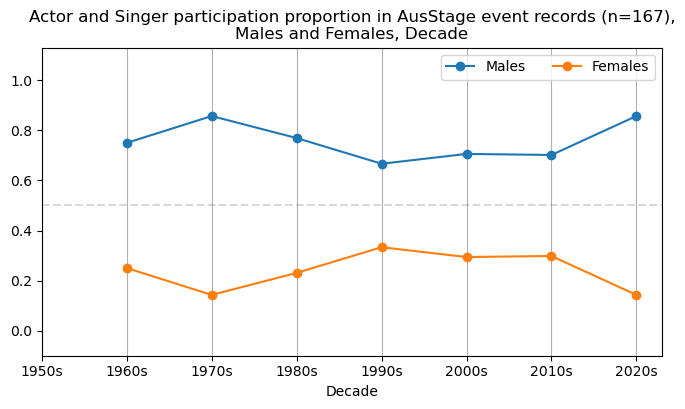

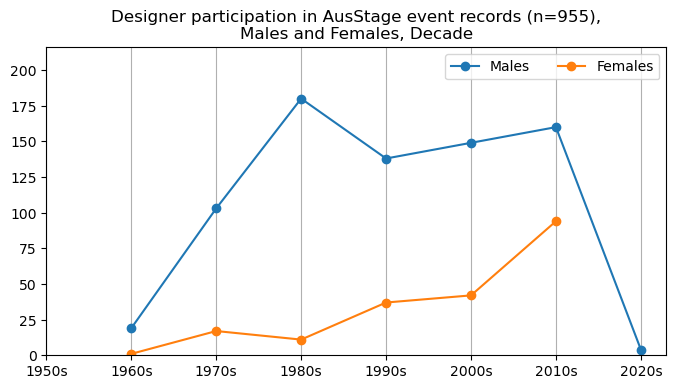

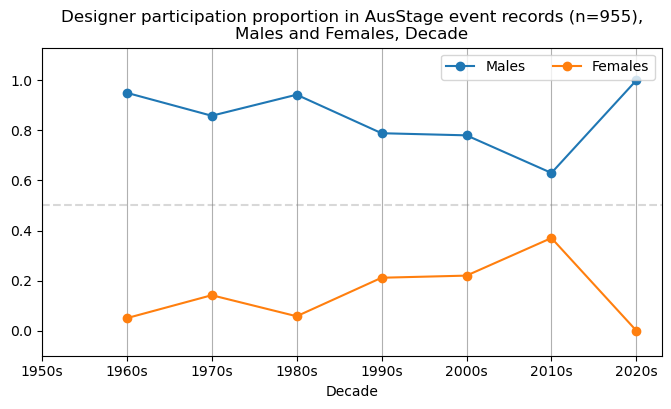

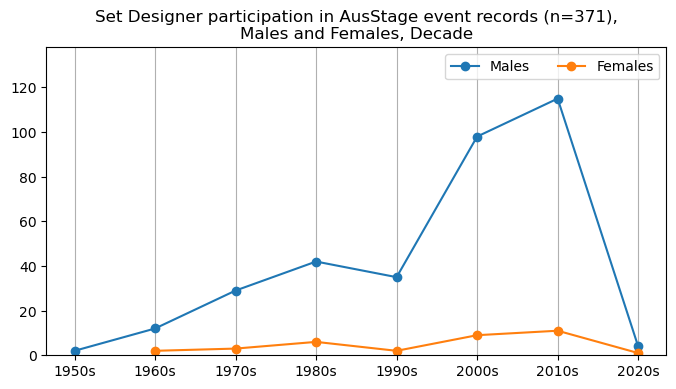

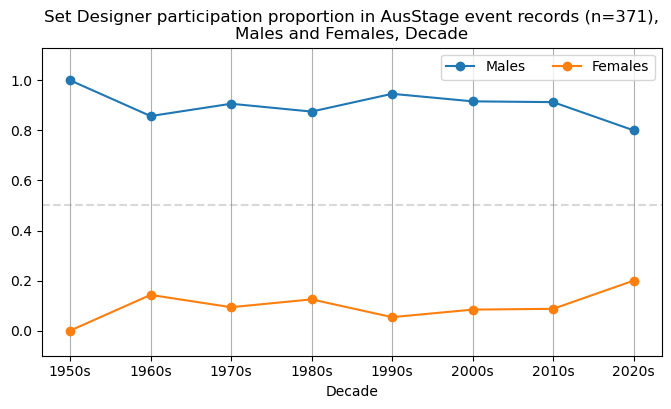

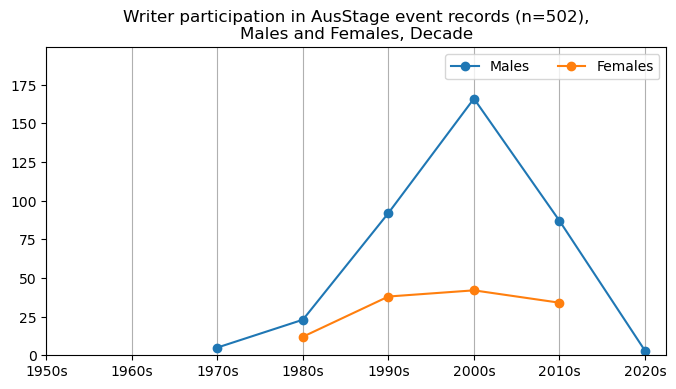

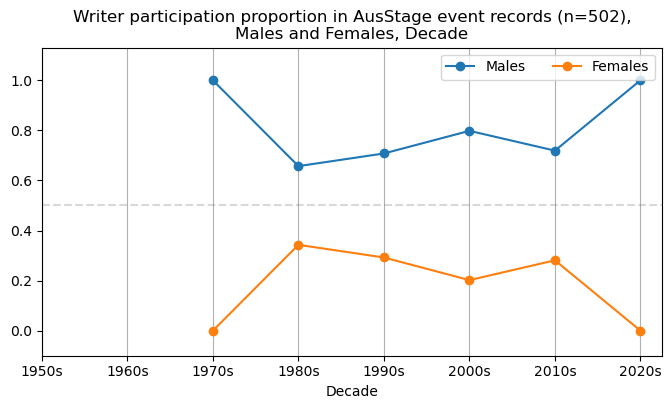

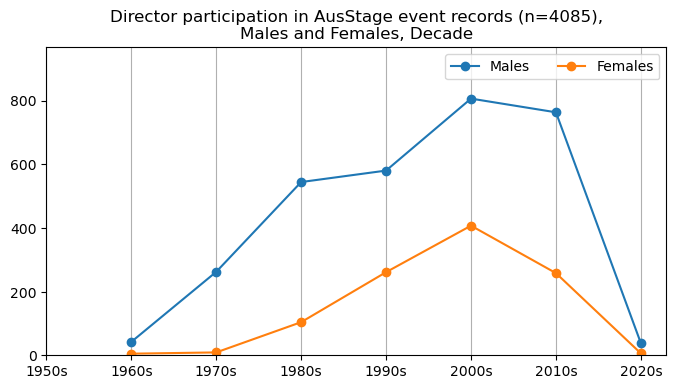

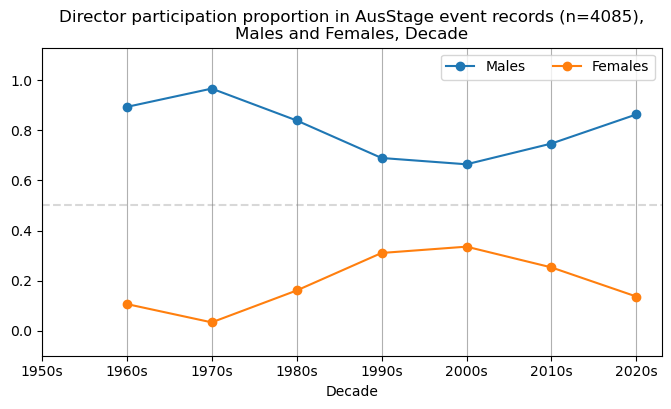

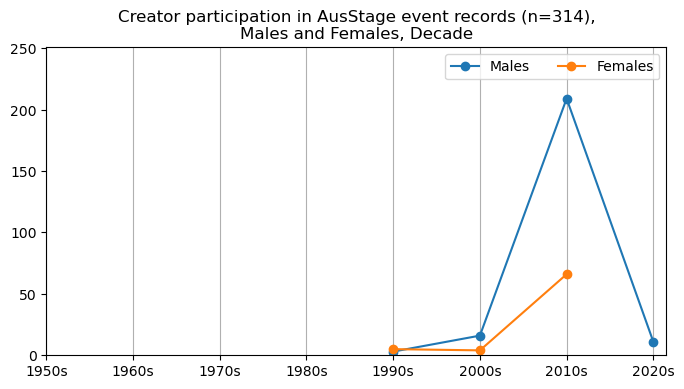

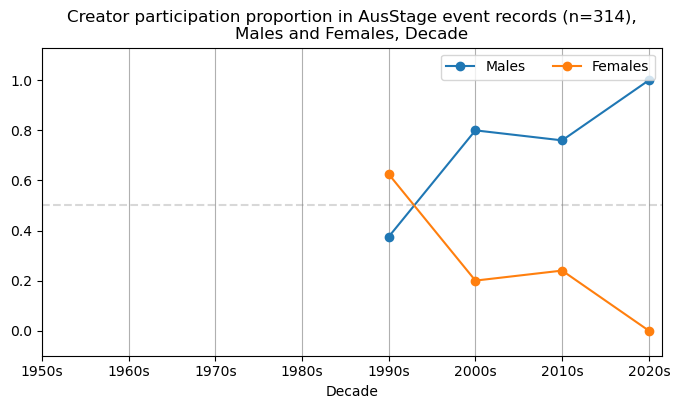

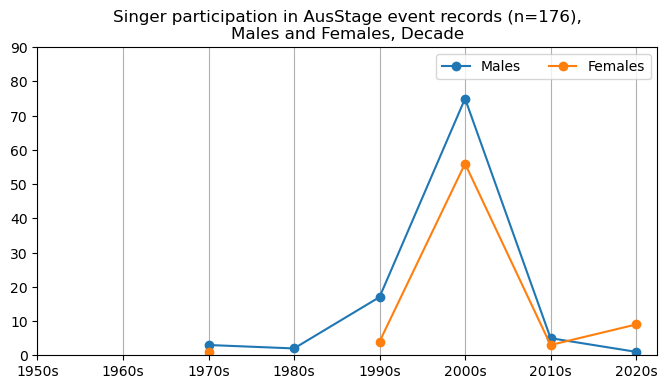

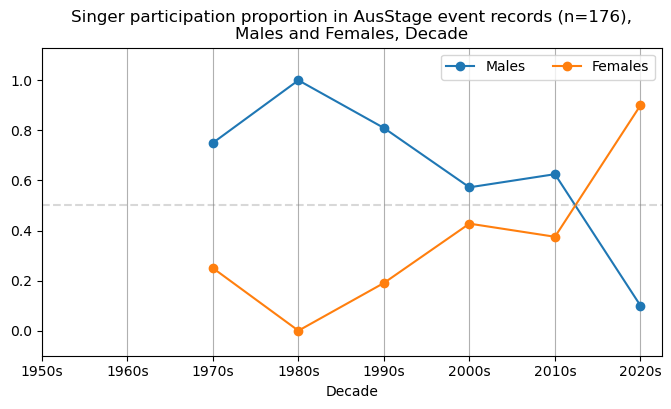

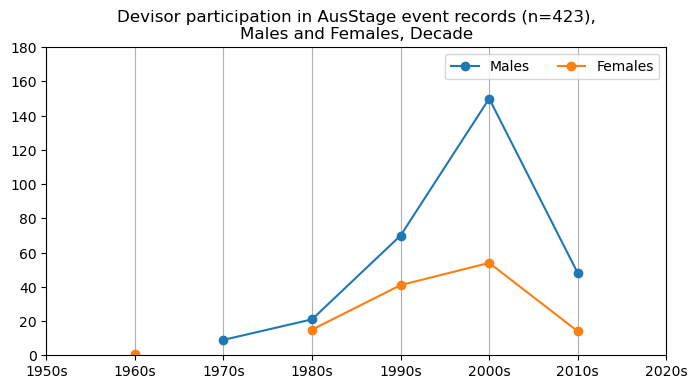

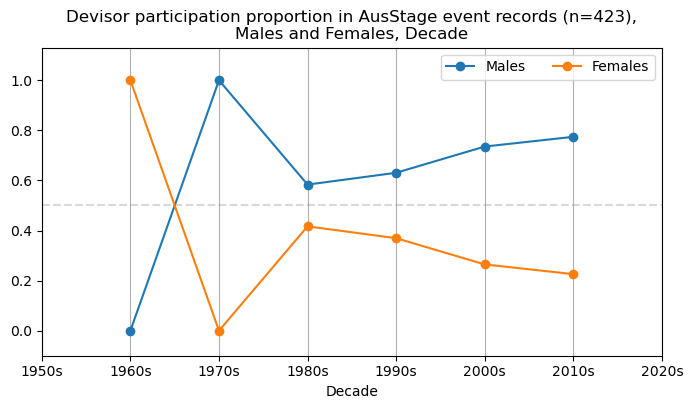

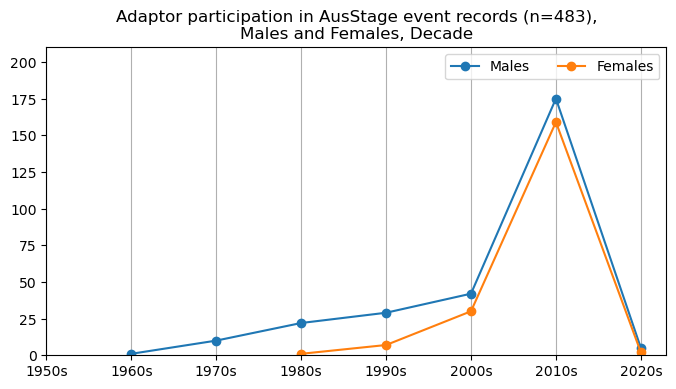

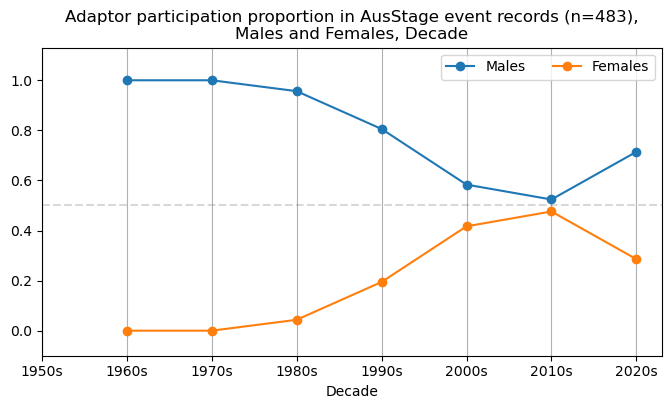

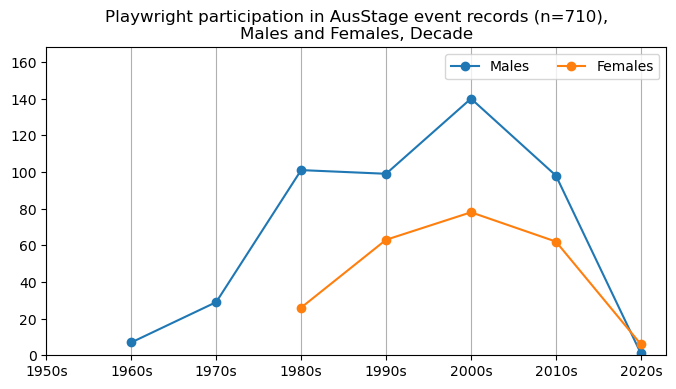

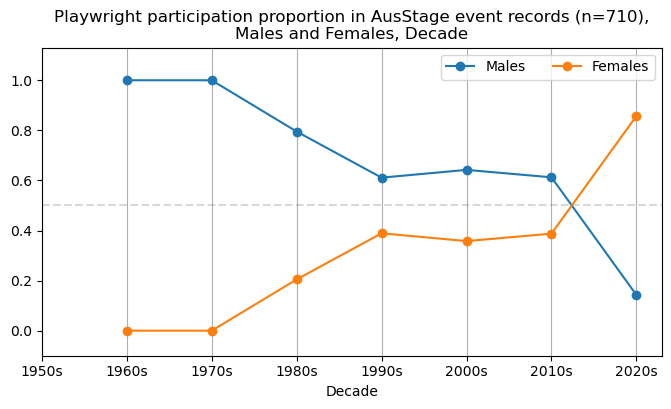

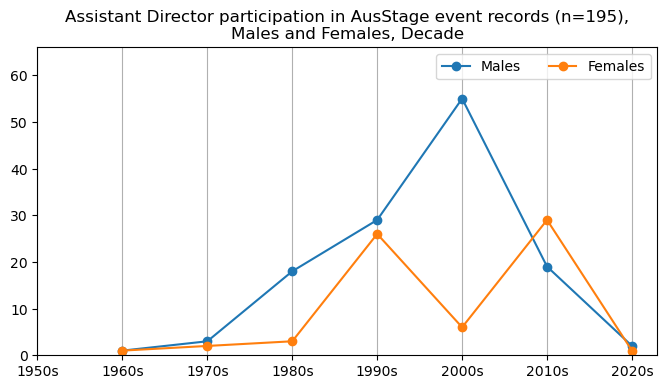

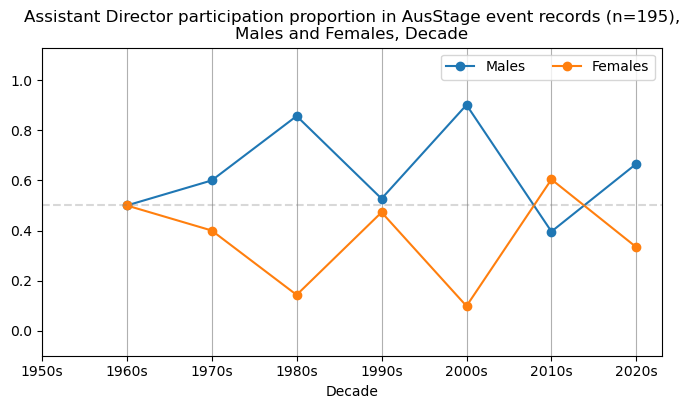

In [569]:
event_data_top15 = event_data[event_data['occupation.title'].isin(top15['occupation.title'])]

events_tab_template = event_data_top15[event_data_top15.gender=='"Male"']['decade']\
    .value_counts()\
    .reset_index()\
    .sort_values('index')

def drilldown_by_role(role='Actor', data=None):
    aa = data[data['occupation.title'] == role]

    # males
    events_males_tab = aa[aa.gender=='"Male"']['decade']\
    .value_counts()\
    .reset_index()\
    .sort_values('index')

    # add decade column for events_males_tab and events_males_tab_template
    events_males_tab = pd.merge(events_males_tab, events_tab_template, on='index', how='outer')\
        .sort_values('index')\
        .drop('decade_y', axis=1)\
        .rename(columns={'decade_x':'decade'})

    events_males_tab['gender'] = 'Male'

    # females
    events_females_tab = aa[aa.gender =='"Female"']['decade']\
    .value_counts()\
    .reset_index()\
    .sort_values('index')

    # add decade column for events_females_tab and events_males_tab_template
    events_females_tab = pd.merge(events_females_tab, events_tab_template, on='index', how='outer')\
        .sort_values('index')\
        .drop('decade_y', axis=1)\
        .rename(columns={'decade_x':'decade'})

    events_females_tab['gender'] = 'Female'

    total_count = events_males_tab['decade'].sum() + events_females_tab['decade'].sum()

    # gender frequency over decade
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.plot(events_males_tab['index'], 
                events_males_tab['decade'], 
                label="Males", marker='o')
    plt.plot(events_females_tab['index'], 
                events_females_tab['decade'], 
                label="Females", marker='o')

    plt.xticks(range(0, 8, 1), 
        ['1950s', '1960s','1970s', '1980s', '1990s','2000s', '2010s', '2020s'])
    plt.grid(axis='x')
    if events_males_tab['decade'].max() > events_females_tab['decade'].max():
        plt.ylim(0,events_males_tab['decade'].max()*1.2)
    else: plt.ylim(0,events_females_tab['decade'].max()*1.2)
    plt.title(f'{role} participation in AusStage event records (n={int(total_count)}),\nMales and Females, Decade')
    ax.legend(loc="upper right", ncol=2)
    plt.show()

    # gender proportion over decade
    fig, ax = plt.subplots(figsize=(8, 4))
    ff = pd.DataFrame(pd.crosstab(aa['decade'],
                aa['gender'],normalize='index')['"Female"']).reset_index()
    ff = pd.merge(ff, events_tab_template, left_on='decade', right_on='index', how='outer')\
        .sort_values('index')\
        .drop(['decade_x','decade_y'], axis=1)\
        .rename(columns={'index':'decade'})

    mm = pd.DataFrame(pd.crosstab(aa['decade'],
                aa['gender'],normalize='index')['"Male"']).reset_index()
    mm = pd.merge(mm, events_tab_template, left_on='decade', right_on='index', how='outer')\
        .sort_values('index')\
        .drop(['decade_x','decade_y'], axis=1)\
        .rename(columns={'index':'decade'})

    plt.plot(mm['decade'], 
                mm['"Male"'], 
                label="Males", marker='o')
    plt.plot(ff['decade'], 
                ff['"Female"'], 
                label="Females", marker='o')

    ax.legend(loc="upper right", ncol=2)

    plt.xlabel('Decade')
    plt.ylim([-0.1, 1.13])
    plt.xticks(range(0, 8, 1), 
        ['1950s', '1960s','1970s', '1980s', '1990s','2000s', '2010s', '2020s'])
    plt.grid(axis='x')

    # add line at 50% mark
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.3)

    plt.title(f'{role} participation proportion in AusStage event records (n={int(total_count)}),\nMales and Females, Decade')
    plt.show()

for top15role in top15['occupation.title'].unique():
    drilldown_by_role(role=top15role, data=event_data_top15)